In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from cptsim.income import (
    simulate_income, 
    gini_index
)
from cptsim.reporting.income_inequality import (
    plot_lorenz_curve, 
    plot_pre_post_introduction_incomes,
    plot_income_cdf
)
from cptsim.reporting.consumption_inequality import (
    plot_concentration_curve, plot_bought_goods_distribution, agents_to_df
)
from cptsim.tax import plot_progressive_taxation
from cptsim.consumption_goods import (
    fit_and_compare_distributions, 
    get_best_fitting_distribution,
    truncated_sampling,
    plot_prices_distribution
)
from cptsim.simulation import simulate_market
from cptsim.agent import SocialPlanner

In [2]:
%load_ext autoreload
%autoreload 2

### Individual Incomes Distribution ###

Here we sample the individual income using a left-skewed gamma distribution. We consider the post taxation monthly income and, for simplicity, we force the values to lay within the range \$500-\$7500.

In [3]:
income_samples = simulate_income(n=10000, min_income=500, max_income=15000, heavy_tail_factor=1.5)

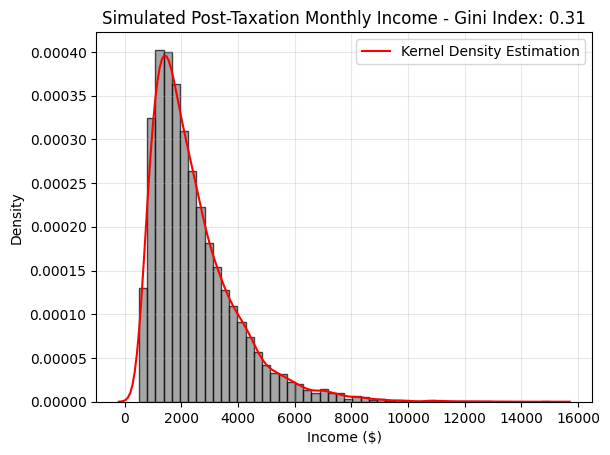

In [4]:
sns.kdeplot(income_samples, c="r", label="Kernel Density Estimation")
plt.grid(alpha=.3)
plt.hist(income_samples, bins=50, density=True, color='gray', alpha=0.7, edgecolor='black')
plt.title(
    f'Simulated Post-Taxation Monthly Income - Gini Index: {gini_index(income_samples):.2f}'
)
plt.xlabel('Income ($)')
plt.ylabel('Density')
plt.legend()
plt.show()

### The Progressive Consumption Tax ###

We use a continuous function to assign the consumption tax to each individual income. For a matter of semplicity, we assume a constant baseline consumption tax of 0.22 (22%).

Here, we propose a scaled logistic function based tax. A scaled logistic function has some interesting properties that make it a good candidate for simulating a progressive tax:
- First, the scaling procedure allows to consider a lower and an upper limit.
- It naturally maps data from the R line to [0, 1].
- Maximum and minimum values can be selected.
- The steepness factor allows to consider different levels of progressivity.

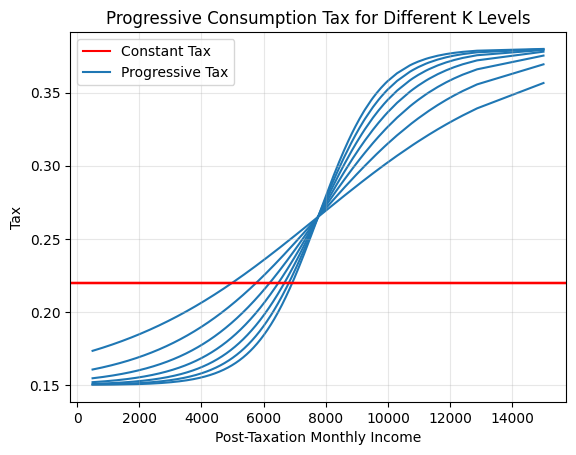

In [5]:
plot_progressive_taxation(income_samples)

### Consumption Goods Prices Distribution ###

For the consumption goods' prices distribution, we use data shared by the [Sparks Foundation](https://www.thesparksfoundationsingapore.org/), available on kaggle at the following URL: https://www.kaggle.com/datasets/roopacalistus/superstore. The data represent a series of about 10k retail transactions that took place in the US.

Here, we suppose that the transactions are limited to goods whose prices are within the range \$1-\$800.

In [6]:
ret2 = pd.read_csv("../data/SampleSuperstore.csv")
ret2 = ret2[(ret2["Sales"] >= 1) & (ret2["Sales"] <= 1000)].reset_index(drop=True)

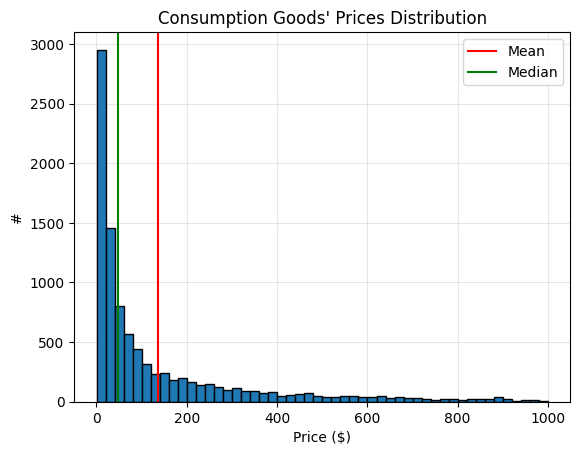

In [7]:
plot_prices_distribution(ret2["Sales"])

Since we want the whole process to be probabilistic, we need a theoretical distribution to sample from to obtain the consumption goods. To do this, we use maximum likelihood to fit a series of probability distribution functions on data. Then, we sample from the theoretical distribution and compute the KL divergence with the empirical one. Finally, we select the parameters of the distribution associated with the lowest KL divergence.

In [8]:
results = fit_and_compare_distributions(ret2["Sales"])
best_dist = get_best_fitting_distribution(results)

In [9]:
theo_price_dist = truncated_sampling(
    best_dist["distribution"], 
    best_dist["parameters"], 
    size=len(ret2["Sales"]), 
    lower_bound=1, 
    upper_bound=1000
)

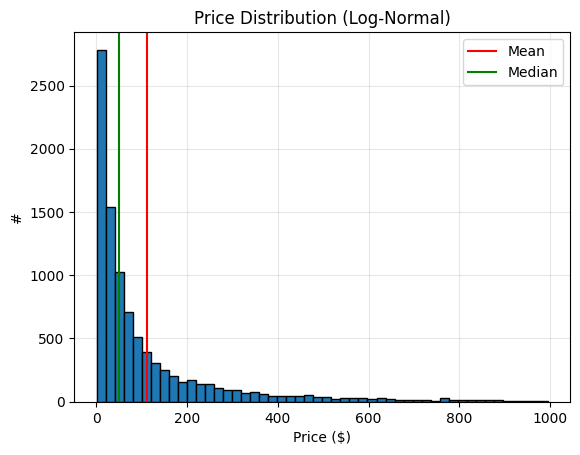

In [10]:
plot_prices_distribution(theo_price_dist, title="Price Distribution (Log-Normal)")

### The Simulation ###

Here we perform the simulation of the economic system. Our main statement is that the introduction of a progressive taxation on consumption goods - represented by the above sigmoid function - at time $t$ would result in more redistributive power for the government at $t+1$. In fact, assuming that the extra budget gathered from an higher taxation for some income classes can be entirely redistributed to lower income individuals at $t + 1$, one can compare the pre and post introduction gini indexes of the income distributions and assess the pre and post introduction inequality. The core assumptions are:
1. The saving rate ($\gamma$) is constant and equal to 20%  of the monthly income.
2. Each economic agent has a monthly income randomly sampled from a gamma distribution clipped between 500 and 7500.
3. At $t$, each economic agent spends his/her income ($Y$) in consumption goods until he/she reaches $(1 - \gamma)*Y$
4. For each consumption good bought, two scenarios are created:
    - One: a taxation ($\omega$), defined by the above sigmoid function is paid.
    - Two: a constant 22% taxation is paid.
5. At $t+1$, the government redistributes the extra budget to lower income individuals, with an amount inversely proportional to the baseline (at $t$) individual income.

In [11]:
agents, gov_budget = simulate_market(best_dist, min_tax=.15, max_tax=.38, heavy_tail_factor=1.5, prog_rate=0.00015, verbose=False)
agents_ct, gov_budget_ct = simulate_market(best_dist, constant_tax=True, heavy_tail_factor=1.5, prog_rate=0.00015)

In [12]:
print(f"Total government budget with progressive consumption taxation: ${gov_budget[0]:.2f}")
print(f"Total government budget with constant taxation: ${gov_budget_ct[0]:.2f}")
print(f"Total difference between budgets: ${gov_budget[0] - gov_budget_ct[0]:.2f}")

Total government budget with progressive consumption taxation: $1768499.58
Total government budget with constant taxation: $1426032.41
Total difference between budgets: $342467.18


### Redistribution of the Extra Budget ###

In [13]:
incomes = [ag.income for ag in agents]

In [14]:
sp = SocialPlanner(agents=agents, budget=gov_budget[0] - gov_budget_ct[0])
tax_df = sp.reassing_extra_budget()

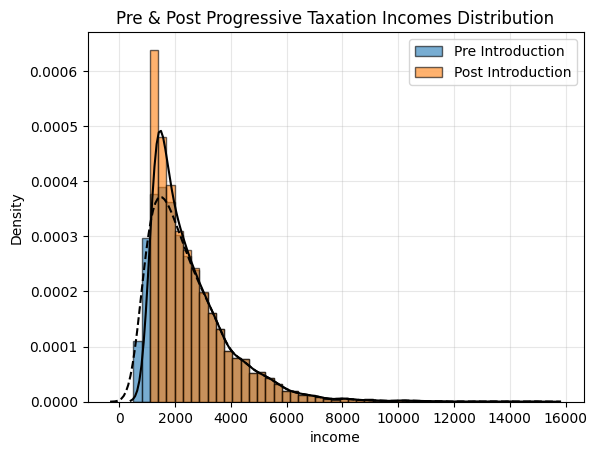

In [15]:
plot_pre_post_introduction_incomes(incomes, tax_df["income"])

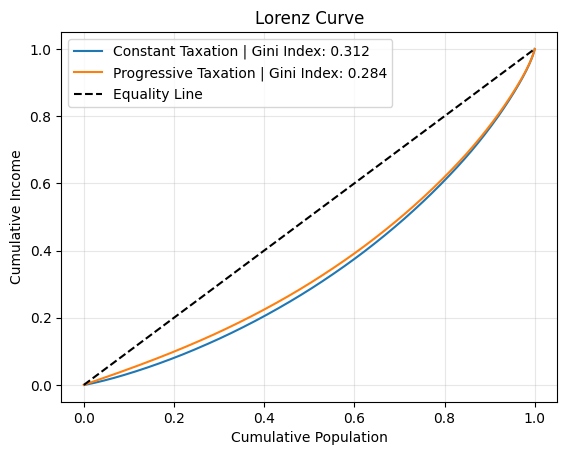

In [16]:
plot_lorenz_curve(incomes, tax_df["income"])

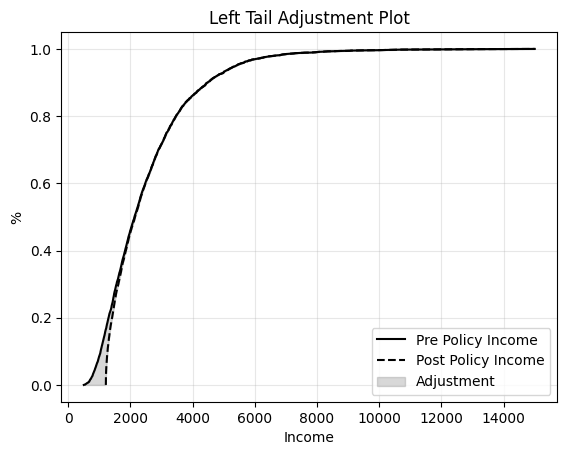

In [17]:
plot_income_cdf(incomes, tax_df["income"])

In [18]:
income_goods = agents_to_df(agents_ct, agents)

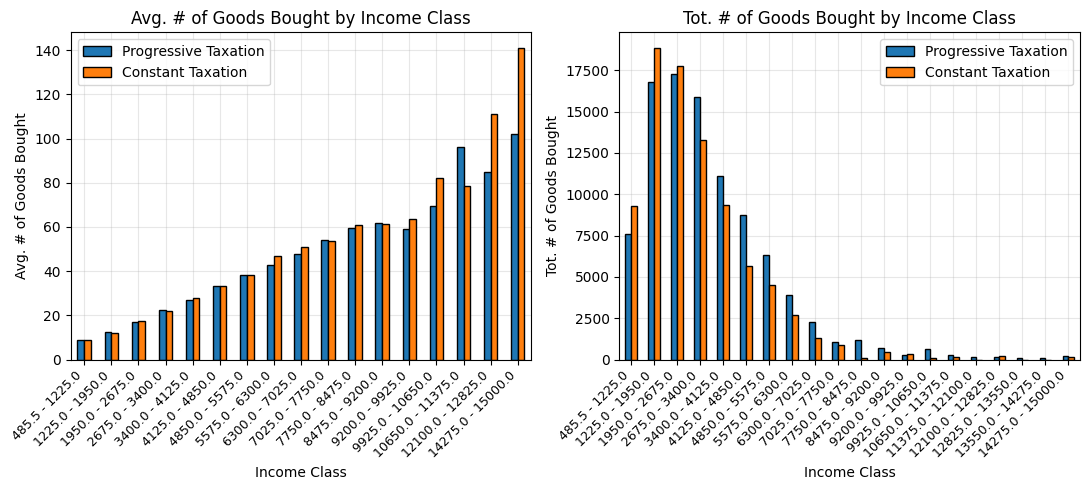

In [19]:
plot_bought_goods_distribution(agents_ct, agents)

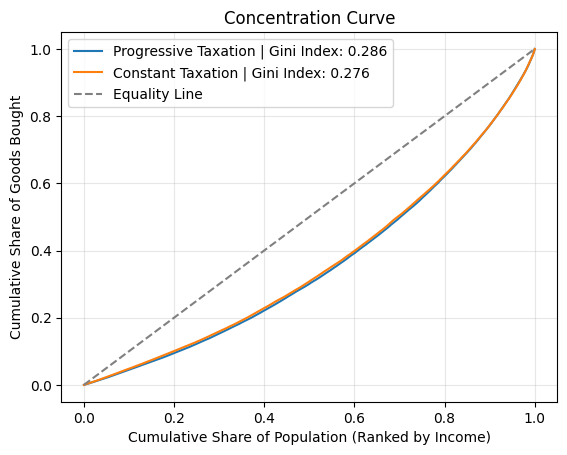

In [20]:
plot_concentration_curve(
    income_goods["income_ct"], 
    income_goods["goods_ct"], 
    income_post=income_goods["income_pt"], 
    goods_post=income_goods["goods_pt"]
)

In [21]:
tot_eco = sp.get_economy_df()

In [22]:
tot_eco.head()

,agent,initial_income,final_income,tax,paid_taxes,bought_goods,paid_prices,savings,income_dynamic
0,0,3467.535144,[0.9137842243777677],0.229284,"[[74.61857712437568], [2.956822501730206], [34...",20,"[[325.4423593175423], [12.89592120528293], [14...",693.507029,"[[2373.967179098877], [2358.1144353918635], [2..."
1,1,2731.623914,[0.6067565379745554],0.223651,"[[1.9634118880284126], [35.03542530465921], [4...",14,"[[8.778916268836175], [156.65233926108147], [2...",546.324783,"[[2174.556802660634], [1982.869038094893], [19..."
2,2,1352.369112,[0.002804150832152025],0.213698,"[[21.34725269338993], [139.4942840277133], [6....",5,"[[99.89432592122171], [652.762567294042], [30....",270.473822,"[[960.6537106518292], [168.39685933007388], [1..."
3,3,1799.143106,[0.04689718912516305],0.216831,"[[1.1520553957744661], [36.6668694769269], [0....",15,"[[5.313159508960563], [169.10378349834892], [2...",359.828621,"[[1432.849269571063], [1227.078616595787], [12..."
4,4,3762.531265,[0.40002904601489553],0.231598,"[[2.7415212574753016], [1.1009572423004859], [...",31,"[[11.837414036558348], [4.753742717887991], [1...",752.506253,"[[2995.4460765039094], [2989.591376543721], [2..."
